# Introduction
[CheatSheet](https://www.kaggle.com/code/raenish/cheatsheet-text-helper-functions/notebook)

Data Source: [kaggle](https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?select=Twitter_Data.csv)
This set of tweets is politics related.

## Import data & packages

In [2]:
# basic
import numpy as np
import pandas as pd
import re
import string
# Preprocessing
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split

# Preprocessing Text 
<a id="1"></a>
Usually the steps includes 

1. Scrape text from raw documents
2. remove punctuation
3. lower case
4. tokenize & remove stop word 
5. lemmatize (lemma or stem)

This is a semi cleaned dataset,so some of the preprocessing is commented out.

In [11]:
def twit_preproc(df,column,now):
    """Preprocessing for df[column]
        process involved: 
            - remove punctuation
            - lower case
            - tokenize & remove stop word 
            - lemmatize (lemma or stem)
        the cleaned column will be df[now]
    """

    def clean_text(text):
        '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
        text = str(text).lower()
        text = re.sub('\[.*?\]', '', text) # remove text in brackets
        text = re.sub('https?://\S+|www\.\S+', '', text) #remove link
        text = re.sub('<.*?>+', '', text) 
        #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text) #remove numbers
        text = re.sub('\w*\d\w*', '', text)
        return text
    df[now]= df[column].apply(lambda x:clean_text(x))
    
    # Tokenize & to lower case
    tokenizer = RegexpTokenizer(r'\w+')
    df[now] = df[now].apply(lambda x:tokenizer.tokenize(x))

    def remove_stopword(x):
        return [y for y in x if y not in stopwords.words('english')]
    df[now] = df[now].apply(lambda x:remove_stopword(x))
    
    # lemmatize and join the words
    #lemmatizer = WordNetLemmatizer()
    #def sentence_lemmatize(text):
    #    return " ".join([lemmatizer.lemmatize(x) for x in text])
    #df[now] = df[now].apply(lambda text:sentence_lemmatize(text))
    
    return df

### Reads data
- `category`: sentiment
    - -1 = Negative
    - 0 = Neutral
    - 1 = Positive

In [3]:
df = pd.read_csv('data/data_2/Twitter_Data.csv')

In [6]:
twit_preproc(df,'clean_text','text')

,clean_text,category,text
0,when modi promised “minimum government maximum...,-1.0,"[modi, promised, minimum, government, maximum,..."
1,talk all the nonsense and continue all the dra...,0.0,"[talk, nonsense, continue, drama, vote, modi]"
2,what did just say vote for modi welcome bjp t...,1.0,"[say, vote, modi, welcome, bjp, told, rahul, m..."
3,asking his supporters prefix chowkidar their n...,1.0,"[asking, supporters, prefix, chowkidar, names,..."
4,answer who among these the most powerful world...,1.0,"[answer, among, powerful, world, leader, today..."
...,...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0,"[crores, paid, neerav, modi, recovered, congre..."
162976,dear rss terrorist payal gawar what about modi...,-1.0,"[dear, rss, terrorist, payal, gawar, modi, kil..."
162977,did you cover her interaction forum where she ...,0.0,"[cover, interaction, forum, left]"
162978,there big project came into india modi dream p...,0.0,"[big, project, came, india, modi, dream, proje..."


In [9]:
# join the tweets
df['text'] = df['text'].apply(lambda text: " ".join(x for x in text))

In [10]:
train, test = train_test_split(df,test_size=0.1)
train.head()

,clean_text,category,text
115134,adjourns hearing stay modi film,0.0,adjourns hearing stay modi film
74696,calling for discipline branded autocratic modi...,0.0,calling discipline branded autocratic modi hit...
39523,had been denied bail district judge marie mall...,1.0,denied bail district judge marie mallon first ...
2458,official website ashok modi – serving the soci...,0.0,official website ashok modi serving society
84192,this why word neech can replace with narendra ...,0.0,word neech replace narendra modi


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146682 entries, 115134 to 7382
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  146678 non-null  object 
 1   category    146675 non-null  float64
 2   text        146682 non-null  object 
dtypes: float64(1), object(2)
memory usage: 4.5+ MB


In [13]:
train = train.dropna()
test = test.dropna()
print("Training set has {} rows, and testing set has {} rows".
     format(train.shape[0],test.shape[0]))

Training set has 146671 rows, and testing set has 16298 rows


# EDA
<a id="2"></a>
- [distribution](#c2.1)
- [Wordcloud](#c2.2)

<a id="c2.1"></a>
## Distribution of Sentiments

In [15]:
def plot_dist(df,column):
    count = df.loc[:,column].value_counts()
    frequency = df.loc[:,column].value_counts(normalize=True)
    return pd.concat([count,frequency],axis=1,keys=['count','frquency'])

In [20]:
plot_dist(train,'category')

,count,frquency
1.0,64951,0.442823
0.0,49701,0.338851
-1.0,32023,0.218326


[Text(0.5, 1.0, 'Distribution of Sentiment')]

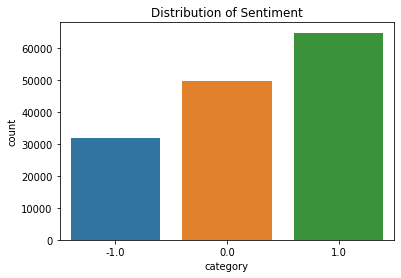

In [21]:
sns.countplot(x='category',data=train).set(title='Distribution of Sentiment')

<a id="c2.2"></a>
## WordCloud

In [60]:
# install the packagge if you havent 
# pip install wordcloud 
from wordcloud import WordCloud

def plot_wordcloud(df,sentiment):
    word = " ".join([twit for twit in df['clean_text'][df['category']==sentiment]])
    wordcloud = WordCloud(width = 800,height=500,random_state=47, max_font_size=100
                     ).generate(word)
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show

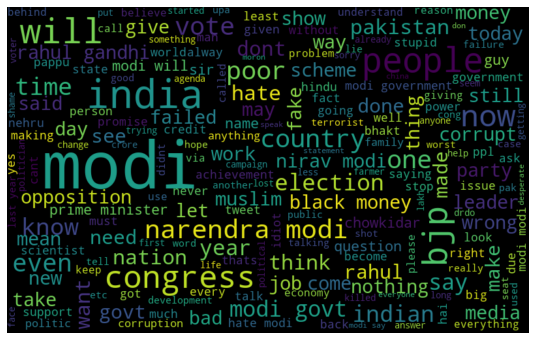

In [50]:
# negative words
plot_wordcloud(train,-1.0)

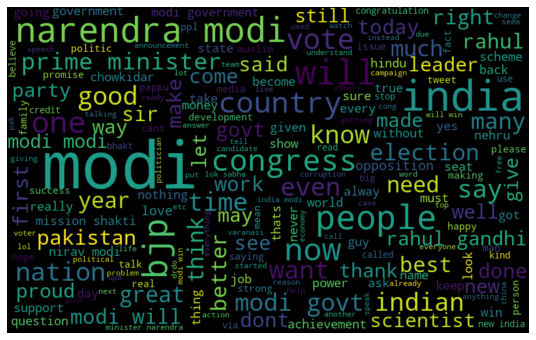

In [61]:
# positive words
plot_wordcloud(train,1)

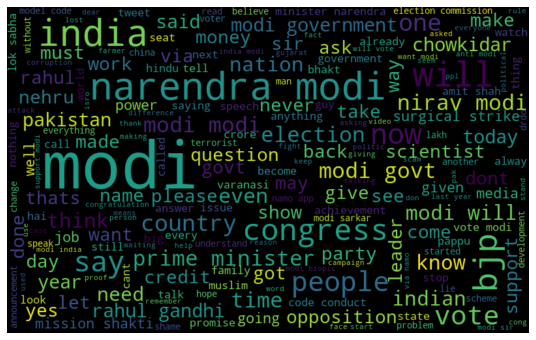

In [62]:
# neutral words
plot_wordcloud(train,0)

### Questions
* Would excluding the common words help with model performance?

# Feature Engineering 
<a id="3"></a>
* [Count Vectorizer](#3.1):

    [Uigram](#3.1.1) |      [Bigram](#3.1.2)  |   [Trigram](#3.1.3) |   [Observation](#3.1.4) 
* [TFiDF Vectorizer](#3.2):

    [Uigram](#3.2.1) |      [Bigram](#3.2.2)  |   [Trigram](#3.2.3) |   [Observation](#3.2.4) 
    

What we are doing in this section is to transform the text into numbers(matrix) so that ML models can understand them. The approach we use is **bag of words** , which ignores the grammar of words and throw them into a vocabulary list. The two methods we experiment with here are **count vectorizer** and **TFIDF**, explained in the following sections.
 
This part is implemented using Ricky Kim's idea and code. Highly recommend reading his medium [series](https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-4-count-vectorizer-b3f4944e51b5).
 


In [63]:
# CODE EXAMPLE
example = CountVectorizer(max_df=0.90, # ignores word with freq > .9
                                 min_df=2, # ignores word with coun < 2
                                 max_features=1200, # size of the dictonary
                                 stop_words='english')
#bow = bow_vectorizer.fit_transform(series)

Thanks to Ricky Kim's brilliant 

I use NB to select max feature and vectorization method. NB is one of the faster algorithms in multiclass classification, DT is also a good choice here.


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from time import time

#### Train Test Split

I ran my selection with a single validation set. If cross validation is used, `accuracy_summary()` needs to be modified.

In [15]:
train, val = train_test_split(train,test_size = 0.10)
print("Training set has {} rows, and validation set has {} rows".
     format(train.shape[0],val.shape[0]))

Training set has 132003 rows, and validation set has 14668 rows


In [17]:
X,x_val = train['text'],val['text']
y,y_val = train['category'],val['category']

The baseline Kim used was the accuracy of guessing the majority, to use the same approach on multiclass classification, I used [**DummyClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html?highlight=dummyclassifier#sklearn.dummy.DummyClassifier). [readmore](https://machinelearningmastery.com/naive-classifiers-imbalanced-classification-metrics/)

In [18]:
dummi = DummyClassifier(strategy="most_frequent")
dummi.fit(X,y)
dum_pred = dummi.predict(x_val)
null_acc = accuracy_score(y_val,dum_pred)

In [19]:
print("The accuracy of simply guessing the majority class is {}%".format(round(null_acc * 100, 3)))
null_acc

The accuracy of simply guessing the majority class is 44.082%


0.4408235614944096

The following functions runs **max feature** and **n-gram** selection.
**Max feature** is the size of our vocabulary in out bag-of-words, meaning the maximum number of unique words allowed in our bag.

**N-grams** are continuous sequences of words or symbols or tokens in a document.

`"I am asleep."`
- n-gram = 1      >>>     [`"I"`,`"am"`,`"asleep"`]
- n-gram = 2      >>>     [`"I am"`,`"am asleep"`]
- n-gram = 3      >>>     [`"I am asleep"`]

In [20]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test, null_accuracy):
    """
    Prints the accuracy score versus baseline accuracy for a given pipeline.
    Baseline accuracy is result from running majority classification.
    
        Keyword arguments:
            pipeline -- fit transform methods
            x_train -- training set features
            y_train -- training set target
            x_test -- testing set features
            y_test -- testing set target
            null_accuracy -- baseline accuracy for the dataset
            
    Return: accuracy, train_test_time
    """
    # Baseline Rules, if CV is used, then the dummyclassification should be run each time.
    null_accuracy = round(null_accuracy,4)
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = round(accuracy_score(y_test, y_pred),4)
    
    print ("null accuracy: {}%".format(null_accuracy*100))
    print ("accuracy score: {}%".format(accuracy*100,2))
    # comaprison to baseline rule
    if accuracy > null_accuracy:
        print ("model is {}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {}s".format(round(train_test_time,2)))
    print ("-"*80)
    
    return accuracy, train_test_time

In [21]:
cvec = CountVectorizer()
mnb = MultinomialNB()
n_features = np.arange(1000,12000,1000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, ngram_range=(1, 1), classifier=mnb):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        # give it your train/val set & baseline accuracy here
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, X, y, x_val, y_val,null_acc)
        result.append((n,nfeature_accuracy,tt_time))
    return result

<a id="3.1"> </a>
### Count Vectorizer Feature Selection

[**Count Vectorizer**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) simply counts the number of occurence of a word in a sentence. 

We will first run our feature selection on count vectorizer.

<a id="3.1.1"> </a>
#### Unigram 

In [154]:
%%time
print ("RESULT FOR UNIGRAM")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM
MultinomialNB()


Validation result for 1000 features
null accuracy: 44.55%
accuracy score: 72.47%
model is 27.92% more accurate than null accuracy
train and test time: 2.48s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 44.55%
accuracy score: 76.03%
model is 31.479999999999997% more accurate than null accuracy
train and test time: 2.5s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 44.55%
accuracy score: 77.02%
model is 32.47% more accurate than null accuracy
train and test time: 2.48s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 44.55%
accuracy score: 77.17%
model is 32.620000000000005% more accurate than null accuracy
train and test time: 2.44s
-------------------------------------------------------------------

<a id="3.1.2"> </a>
#### Bigram

In [155]:
%%time
print ("RESULT FOR BIGRAM")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))

RESULT FOR BIGRAM
MultinomialNB()


Validation result for 1000 features
null accuracy: 44.55%
accuracy score: 70.22%
model is 25.670000000000005% more accurate than null accuracy
train and test time: 9.08s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 44.55%
accuracy score: 73.53%
model is 28.979999999999993% more accurate than null accuracy
train and test time: 8.22s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 44.55%
accuracy score: 74.63%
model is 30.079999999999995% more accurate than null accuracy
train and test time: 8.24s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 44.55%
accuracy score: 74.99%
model is 30.44% more accurate than null accuracy
train and test time: 8.08s
------------------------------------------------------

<a id="3.1.3"> </a>
#### Trigram

In [156]:
%%time
print ("RESULT FOR TRIGRAM")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(2, 3))

RESULT FOR TRIGRAM
MultinomialNB()


Validation result for 1000 features
null accuracy: 44.55%
accuracy score: 48.05%
model is 3.4999999999999973% more accurate than null accuracy
train and test time: 15.29s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 44.55%
accuracy score: 49.480000000000004%
model is 4.9300000000000015% more accurate than null accuracy
train and test time: 14.96s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 44.55%
accuracy score: 50.56%
model is 6.010000000000004% more accurate than null accuracy
train and test time: 13.86s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 44.55%
accuracy score: 51.39%
model is 6.840000000000002% more accurate than null accuracy
train and test time: 15.5s
--------------------------

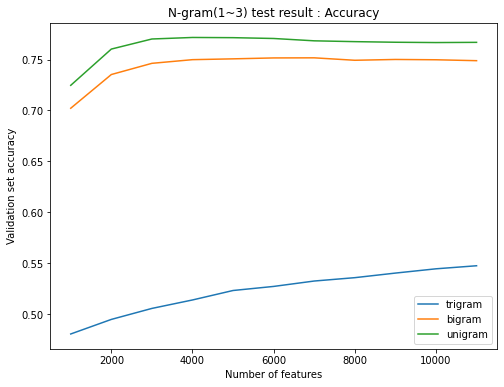

In [164]:
#plot the n-grams
plt_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','t'])
plt_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','t'])
plt_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','t'])

plt.figure(figsize=(8,6))
plt.plot(plt_tg.nfeatures, plt_tg.validation_accuracy,label='trigram')
plt.plot(plt_bg.nfeatures, plt_bg.validation_accuracy,label='bigram')
plt.plot(plt_ug.nfeatures, plt_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

<a id="3.1.4"></a>
### Observations

- Unigram does the best at 4000 features with 77.17% accuracy. 
- Bigram best performance at 7000 feature 75.17%.
- Trigram potentially performs better with higher feature, but that might require more data or text with longer content.

<a id="3.2"> </a>
## TFIDF 
Term Frequency-Inverse Document Frequency. This is another vectorization method which takes into consideration of a word's contribution to the meaning of the corpus(in this case the collection of all tweets). The each word is assigned a value by the following formula.

$$TF * log(IDF)$$ where $$TF(t,d) = \frac{\text {occurance of } t}{|d|}$$ and $$IDF(t,D) = \frac{|D|}{\text{count }(d\in D, t\in d)} $$

In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

<a id="3.2.1"> </a>
### Unigram 

In [160]:
%%time
print ("RESULT FOR UNIGRAM")
feature_result_ug_t = nfeature_accuracy_checker(vectorizer=tvec)

RESULT FOR UNIGRAM
MultinomialNB()


Validation result for 1000 features
null accuracy: 44.55%
accuracy score: 68.01%
model is 23.460000000000004% more accurate than null accuracy
train and test time: 2.67s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 44.55%
accuracy score: 70.92%
model is 26.370000000000005% more accurate than null accuracy
train and test time: 2.55s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 44.55%
accuracy score: 71.69%
model is 27.139999999999997% more accurate than null accuracy
train and test time: 2.64s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 44.55%
accuracy score: 71.93%
model is 27.380000000000003% more accurate than null accuracy
train and test time: 2.66s
----------------------------------------

<a id="3.2.2"> </a>
### Bigram 

In [167]:
%%time
print ("RESULT FOR BIGRAM")
feature_result_bg_t = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))

RESULT FOR BIGRAM
MultinomialNB()


Validation result for 1000 features
null accuracy: 44.55%
accuracy score: 67.36999999999999%
model is 22.819999999999997% more accurate than null accuracy
train and test time: 9.63s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 44.55%
accuracy score: 70.54%
model is 25.990000000000002% more accurate than null accuracy
train and test time: 9.38s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 44.55%
accuracy score: 71.69%
model is 27.139999999999997% more accurate than null accuracy
train and test time: 9.53s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 44.55%
accuracy score: 72.26%
model is 27.71% more accurate than null accuracy
train and test time: 9.2s
-------------------------------------------

<a id="3.2.3"> </a>
### Trigram 

In [168]:
%%time
print ("RESULT FOR TRIGRAM")
feature_result_tg_t = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(2,3))

RESULT FOR TRIGRAM
MultinomialNB()


Validation result for 1000 features
null accuracy: 44.55%
accuracy score: 48.97%
model is 4.420000000000002% more accurate than null accuracy
train and test time: 16.07s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 44.55%
accuracy score: 50.6%
model is 6.05% more accurate than null accuracy
train and test time: 16.29s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 44.55%
accuracy score: 51.83%
model is 7.279999999999998% more accurate than null accuracy
train and test time: 16.24s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 44.55%
accuracy score: 52.669999999999995%
model is 8.119999999999994% more accurate than null accuracy
train and test time: 16.31s
-----------------------------------------

Lets plot the performance of both verctorizer together to see which performs better.

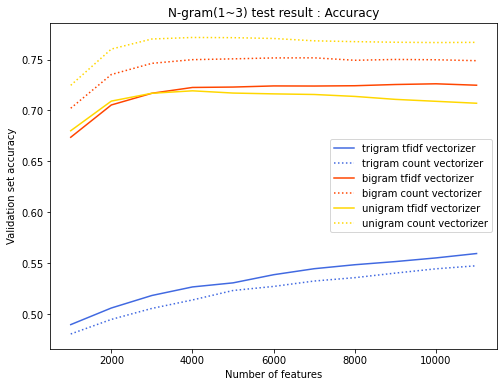

In [169]:
plt_tgt = pd.DataFrame(feature_result_tg_t,columns=['nfeatures','validation_accuracy','t'])
plt_bgt = pd.DataFrame(feature_result_bg_t,columns=['nfeatures','validation_accuracy','t'])
plt_ugt = pd.DataFrame(feature_result_ug_t,columns=['nfeatures','validation_accuracy','t'])

plt.figure(figsize=(8,6))
plt.plot(plt_ugt.nfeatures, plt_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(plt_tg.nfeatures, plt_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(plt_ugt.nfeatures, plt_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(plt_bg.nfeatures, plt_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(plt_ugt.nfeatures, plt_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(plt_ug.nfeatures, plt_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

<a id="3.2.4"></a>
### Observations

- Count Vectorizer has the best performance on NB model.
- Overall count vectorizer with Unigram does the best at 4000 features with 77.17% accuracy. 
- In Kim's project, TIFDI and trigram yields better result, he did not remove stop words so have longer tweets, also he has significantly larger dataset(sentiment160). So the difference is resonable, we will continue improving our model from using **count vectorizer with 4000 features.**

# Modelling
<a id="4"></a>
Models for multiclass classification. Some binary classfication can also be used, we will explore that in later section.
* k-Nearest Neighbors.
* Decision Trees.
* Berinoulli Naive Bayes.
* Logistic Regression ([multinomial lr](https://machinelearningmastery.com/multinomial-logistic-regression-with-python/))
* Random Forest.
* Gradient Boosting.

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

names = ["Mutinomial Logistic Regression","Bernoulli NB", "Multinomial NB", "Decision Tree","KNN"]
classifiers = [
    LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000),
    BernoulliNB(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    KNeighborsClassifier()
    ]
zipped_clf = zip(names,classifiers)

In [50]:
def classifier_comparator(vectorizer=cvec, n_features=4000, ngram_range=(1, 1), classifier=zipped_clf):
    """
    Performs Model Selection on our data set.
    Default parameters based on our previous feature selection
    Returns a list of performance = [model, accuracy, runtime]
    """
    result = []
    vectorizer.set_params(max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c) 
        # input dataset and baseline score here
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, X, y, x_val, y_val,null_acc)
        result.append((n,clf_accuracy,tt_time))
    return result

In [51]:
%%time
unigram_result = classifier_comparator()

Validation result for Mutinomial Logistic Regression
LogisticRegression(max_iter=1000, multi_class='multinomial')
null accuracy: 44.080000000000005%
accuracy score: 88.85%
model is 44.769999999999996% more accurate than null accuracy
train and test time: 13.9s
--------------------------------------------------------------------------------
Validation result for Bernoulli NB
BernoulliNB()
null accuracy: 44.080000000000005%
accuracy score: 79.12%
model is 35.04% more accurate than null accuracy
train and test time: 2.48s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB()
null accuracy: 44.080000000000005%
accuracy score: 77.86%
model is 33.779999999999994% more accurate than null accuracy
train and test time: 2.45s
--------------------------------------------------------------------------------
Validation result for Decision Tree
DecisionTreeClassifier()
null accuracy: 44.080000000000005%
accuracy score: 8

The result suggests that **logistic regression** has the best performance out of the simple models, with performance **45%** more accurate than null accuracy.

We should finetune it, but we should also run some more costly models and see their performance. 

In [52]:
unigram_result

[('Mutinomial Logistic Regression', 0.8885, 13.903324127197266),
 ('Bernoulli NB', 0.7912, 2.4823720455169678),
 ('Multinomial NB', 0.7786, 2.448934316635132),
 ('Decision Tree', 0.829, 69.3138780593872),
 ('KNN', 0.492, 69.90551590919495)]

#### RandomForest

In [32]:
from sklearn.ensemble import RandomForestClassifier

my_cvec = CountVectorizer(max_features=4000, ngram_range=(1,1))

my_pipeline = Pipeline([
    ('vectorizer', my_cvec),
    ('classifier', RandomForestClassifier())
])


In [33]:
%%time
rf_result = accuracy_summary(my_pipeline,X,y,x_val,y_val,null_acc)

null accuracy: 44.080000000000005%
accuracy score: 86.92%
model is 42.839999999999996% more accurate than null accuracy
train and test time: 389.27s
--------------------------------------------------------------------------------
CPU times: user 6min 22s, sys: 3 s, total: 6min 25s
Wall time: 6min 29s


We can see that RF also does a good job, but given its costly runtime, we will not consider using it. 

**Visualize the result of model performances**

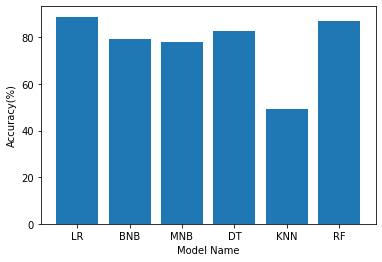

In [54]:
plot_res_x = ['LR','BNB','MNB','DT','KNN','RF']
plot_res_y = [round(r[1]  * 100, 2) for r in unigram_result] + [round(100*rf_result[0],2)]

plt.bar(plot_res_x, plot_res_y,)
plt.ylabel('Accuracy(%)')
plt.xlabel('Model Name')
plt.show()